# enhanced_sampling

- Why do we need enhanced sampling?
- Using `PLUMED` and `mlcolvar` to analyze and run simulations
- Traditional enhanced sampling: `Metadynamics` and `OPES`


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from mlcolvar.utils.plot import paletteFessa

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PLUMED
A plugin for free energy calculations, enhanced sampling and analysis


# Mlcolvar library
A python library for the use and development of machine learning collective variables for enhanced sampling

# Our hero: the Muller-Brown potential

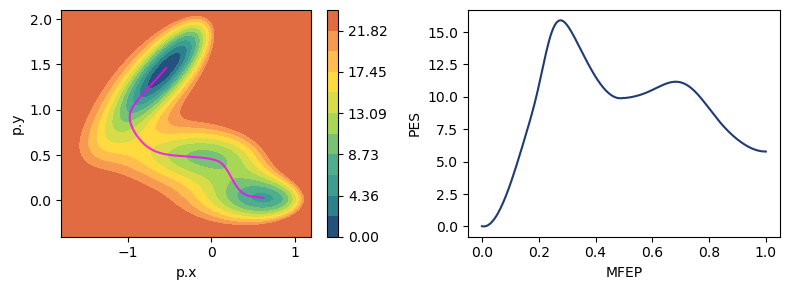

In [3]:
from mlcolvar.utils.plot import plot_isolines_2D, muller_brown_potential, muller_brown_mfep

fig, axs = plt.subplots(ncols=2, figsize=(8,3))

# 2D potential energy surface (PES)
ax = axs[0]
mfep = muller_brown_mfep()
plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=True)
ax.plot(mfep[:, 0], mfep[:, 1], color='magenta', alpha=0.8)
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

# 1D projection of PES along the minimum free energy path (MFEP)
ax = axs[1]
fes_mfep = muller_brown_potential(mfep[:, 0], mfep[:, 1])
ax.plot(np.linspace(0,1,200), fes_mfep, c=paletteFessa[0])
ax.set_xlabel('MFEP')
ax.set_ylabel('PES')
plt.tight_layout()
plt.show()

# Why do we need enhanced sampling?

At low temperature (kBT=1) the barriers are so high that it would take forever to cross them

<center><img src="../figures/rare_event.png" width="600" /></center>

$$\text{For M\"uller:} \quad 1\,\text{forever} \simeq e^{\Delta G / k_BT} \simeq 10^6 $$ 


We can try to se what happens if we try to run a simulation starting from the two basins, so we can start familiarizing with the system and the machinery

In [3]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_unbiased_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


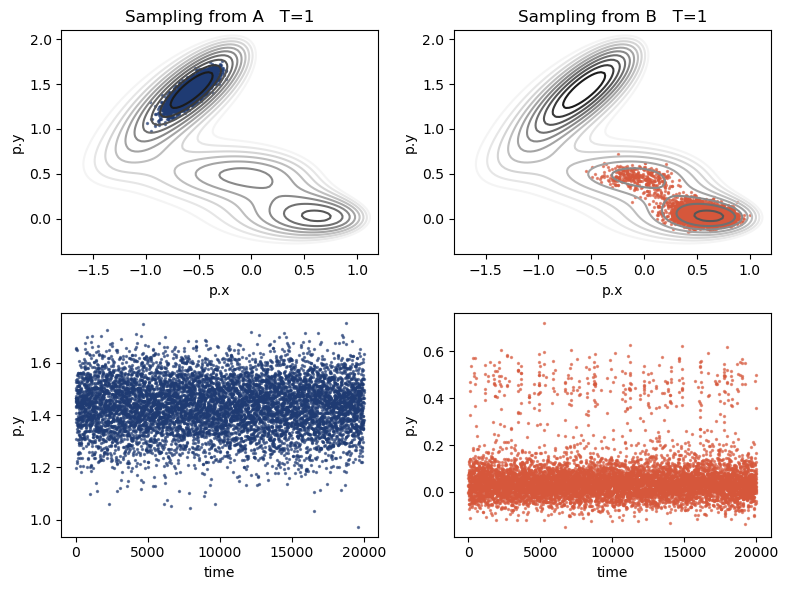

In [34]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/unbiased_sims/A/COLVAR', f'simulations/unbiased_sims/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   T=1')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

We can thus raise the temeprature a little bit (kBT=1.5)

In [35]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_unbiased_highT_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_highT_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_highT_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


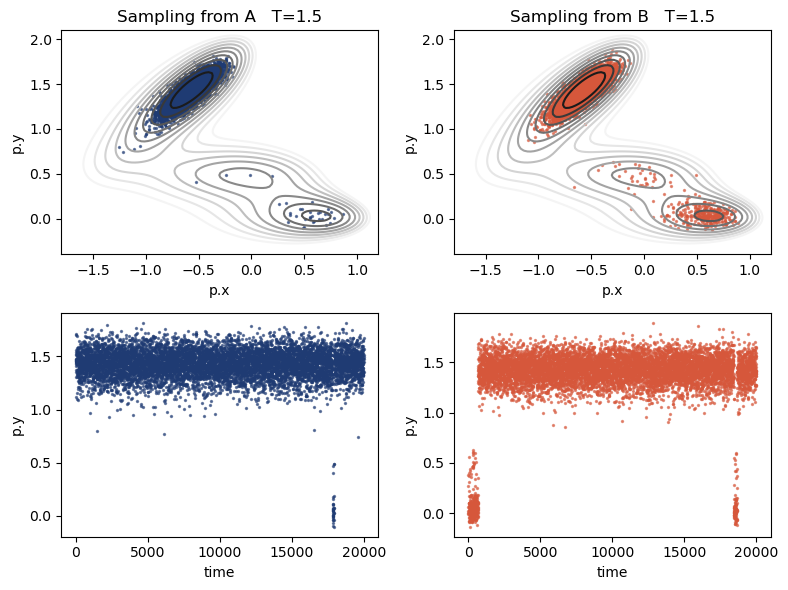

In [46]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/unbiased_highT_sims/A/COLVAR', f'simulations/unbiased_highT_sims/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   T=1.5')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

It gets a little bit better but it's still far from efficient, so we can try to heat it more (kBT=3)

In [47]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_unbiased_crazyT_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_unbiased_crazyT_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_unbiased_crazyT_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


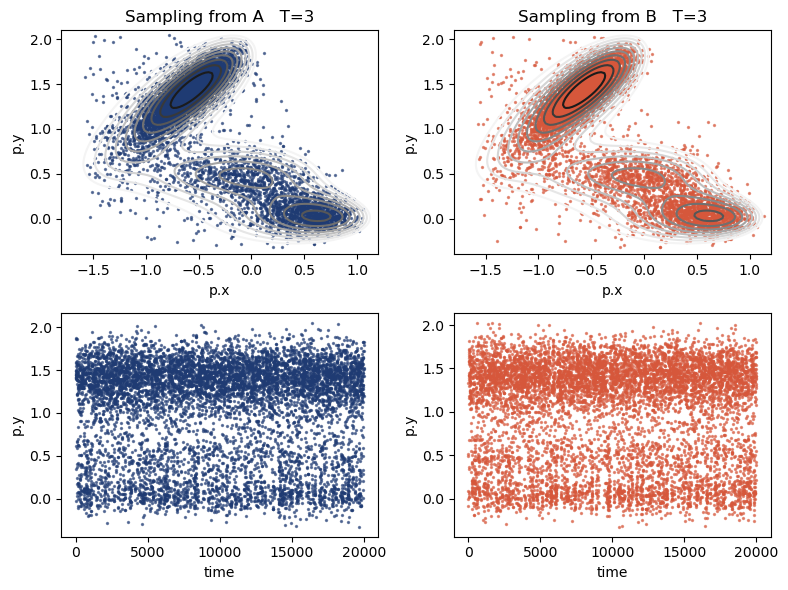

In [56]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/unbiased_crazyT_sims/A/COLVAR', f'simulations/unbiased_crazyT_sims/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   T=3')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

Raising the temperature can help, but you must be carfeul!

This is a toy model, imagine what can happen with a protein!

<center><img src="../figures/transitions_cost.jpg" width="400" /></center>

Raising the temperature doesn't give much *control* on your simulations!

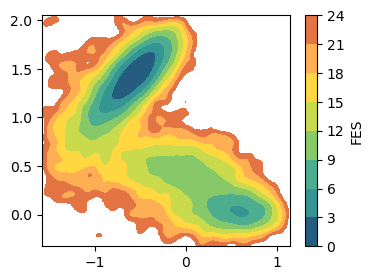

In [57]:
from mlcolvar.utils.fes import compute_fes
fig, ax = plt.subplots(1,1,figsize=(4, 3))
fes,bins,_,_ = compute_fes(sampling[['p.x', 'p.y']].values, kbt=4, plot=True, num_samples=200, eps=1e-6, bandwidth=0.02, scale_by='range', plot_max_fes=24, ax=ax)


# Enhanced sampling 101

We want to promote the transitions between the states with *as much control as possible*

Many enhanced sampling methods are based on the addition of a **external bias potential** $V(x)$ to the natural potential $U(x)$ so as to mitigiate the effect of large free energy barriers and promote transitions.

<center><img src="../figures/prob_dist.png" width="600" /></center>


## Metadynamics (MetaD)
The bias is built on-the-fly by depositing repulsive Gaussians as we move in the phase space until we eventually fill the basins
$$V_n(\textbf{s}) = \sum_k^n \exp[-\frac{\beta V_{k-1}(\textbf{s}_k)}{\gamma-1}] \textbf{G}(\textbf{s}, \textbf{s}_k) \qquad\xrightarrow{n \rightarrow \infty}\qquad V_\gamma(\textbf{s}) = - (1 - \frac{1}{\gamma})F(\textbf{s}) + c(t)$$

<center><img src="../figures/metad.png" width="500" /></center>

---

## On-the-fly Probability Enhanced Sampling (OPES)
It's an evolution of MetaD that is faster and more stable. Here the focus for the bias construction is shifted from the energy to the probability distribution.
The OPES bias aims at sampling a **target probability distribution** $p^{tg}$
$$ V(\textbf{s}) = \frac{1}{\beta} \ln \frac{P(\textbf{s})}{p^{tg}(\textbf{s})}$$
For instance, the well-tempered distribution
$$ p^{tg}(\textbf{s}) = p^{WT}(\textbf{s}) \propto [P(\textbf{s})]^{1/\gamma}$$

Not only, it also have different flavours that can drive different types of sampling

### OPES-Metad
Best solution for converging free energies. The bias quickly becomes quasi-static but requires good CVs.

$$V_n(\textbf{s}) = (1 - \frac{1}{\gamma})\frac{1}{\beta}\ln\big(\frac{P_n(\textbf{s}\big)}{Z_n} + \epsilon) \qquad \text{with}\qquad P_n(\textbf{s}) = \frac{\sum_k^n w_k G(\textbf{s}, \textbf{s}_k)}{\sum_k^n w_k} \quad\text{i.e., KDE}$$


### OPES-Explore
Similar to MetaD (but still better). The bias is updated more aggresively to promote more transitions, even if they are less equilibrated. It can be helpful when the CVs are suboptimal.
$$V_n(\textbf{s}) = (\gamma - 1) \frac{1}{\beta}\ln(\frac{p^{WT}(\textbf{s})}{Z_n} + \epsilon)  \qquad \text{with}\qquad p^{WT}_n(\textbf{s}) = \frac{1}{n}\sum_k^n G(\textbf{s}, \textbf{s}_k)$$


### OPES-Flooding
It fills only **one** basin to collect reactive trajectories that can be used to compute rates from biased simulations as the bias does not affect the transition state.
<center><img src="../figures/flooding.png" width="500" /></center>



### OPES-Expanded
Ask Pablo, he did with Michele :)


## OPES simulations

In [58]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_x_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_x_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_x_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


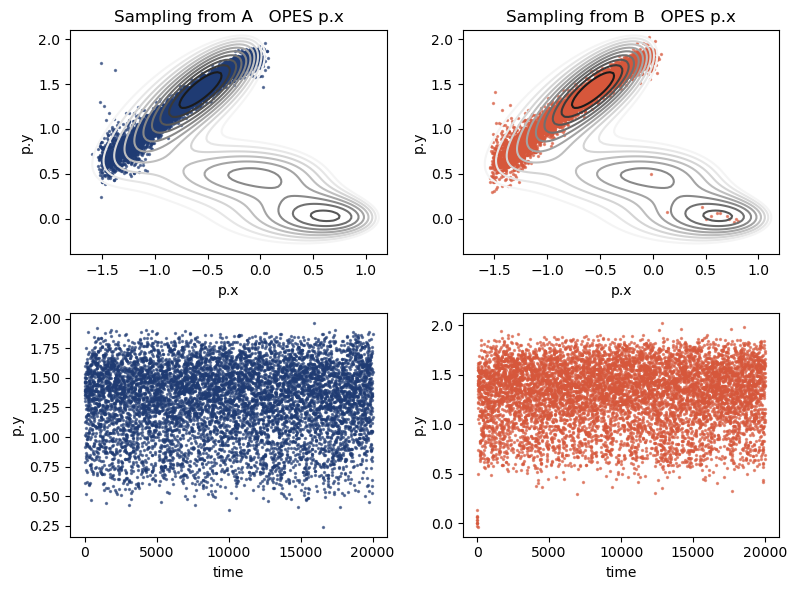

In [140]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_metad_x/A/COLVAR', f'simulations/opes_metad_x/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   OPES p.x')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

In [72]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


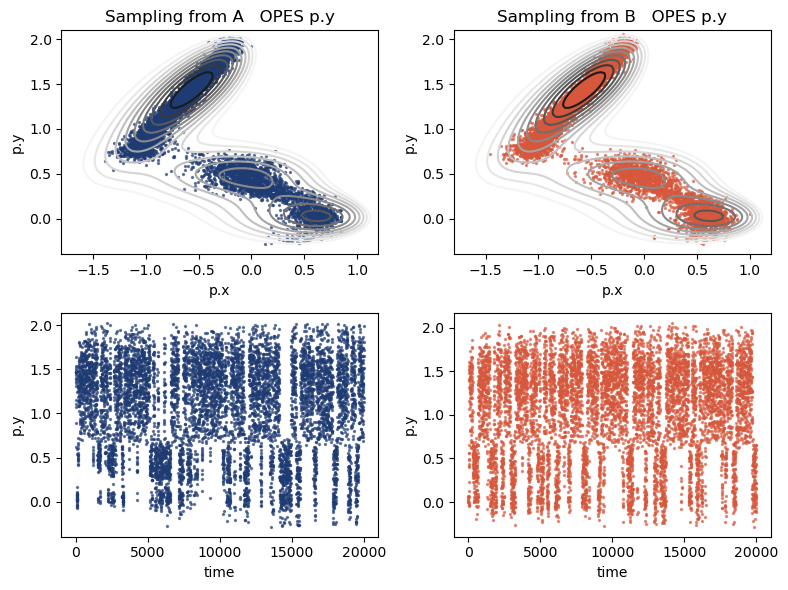

In [92]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_metad_y/A/COLVAR', f'simulations/opes_metad_y/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   OPES p.y')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

In [93]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_explore_x_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_explore_x_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_explore_x_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


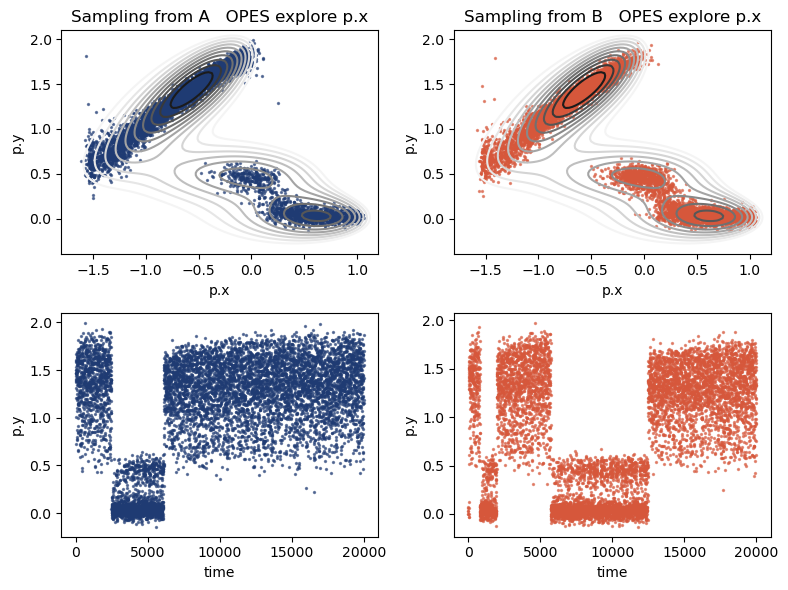

In [111]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_explore_x/A/COLVAR', f'simulations/opes_explore_x/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   OPES explore p.x')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

In [112]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_explore_y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_explore_y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_explore_y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


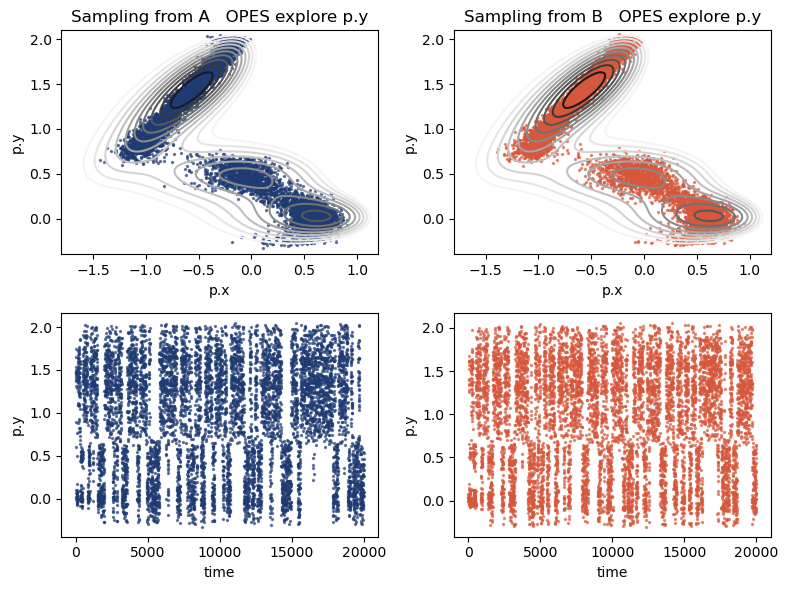

In [4]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_explore_y/A/COLVAR', f'simulations/opes_explore_y/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s}   OPES explore p.y')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()

# Collective variables

- What is a good collective variable?
- Machine learning based collective variables
- mlcolvar library


# What is a (good) collective variable?

In most cases, CVs are not so easy to find.
Conventionally, they have been chosen by chemical/physical intuition relying on physical descriptors such as distances, angles, coordination numbers etc..

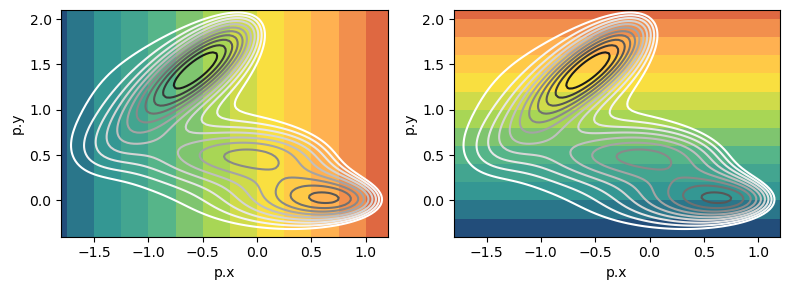

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

ax = axs[0]
plot_isolines_2D(lambda x,y: x , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

ax = axs[1]
plot_isolines_2D(lambda x,y: y , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

plt.tight_layout()
plt.show()

However, this approach is raher limiting as it's difficult to identify them.

One alternative can be, for example, to combine some variables to make them more *collective*.

 The easiest approach is to combine them linearly

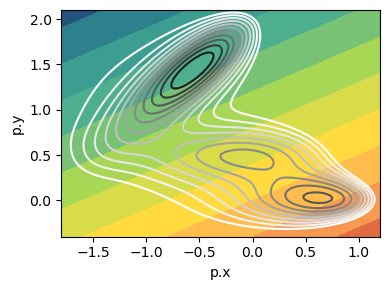

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(4,3))

ax = axs
plot_isolines_2D(lambda x,y: 0.5*x-y , ax=ax, colorbar=False)
plot_isolines_2D(muller_brown_potential, ax=ax, colorbar=False, mode='contour', levels=np.linspace(0,24, 12))
ax.set_xlabel('p.x')
ax.set_ylabel('p.y')

plt.tight_layout()
plt.show()

In [ ]:
import subprocess

RUN_SIMULATION = "bash submission_scripts/run_opes_metad_x-y_sims.sh" 
subprocess.run(f"{RUN_SIMULATION}", shell=True, executable='/bin/bash', stdout=subprocess.DEVNULL)

submission_scripts/run_opes_metad_x-y_sims.sh: line 32: wait: pid 1 is not a child of this shell


CompletedProcess(args='bash submission_scripts/run_opes_metad_x-y_sims.sh', returncode=0)

Invalid MIT-MAGIC-COOKIE-1 keyInvalid MIT-MAGIC-COOKIE-1 key

/home/etrizio@iit.local/Bin/miniconda3/envs/mlcvs_test/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:278: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn(


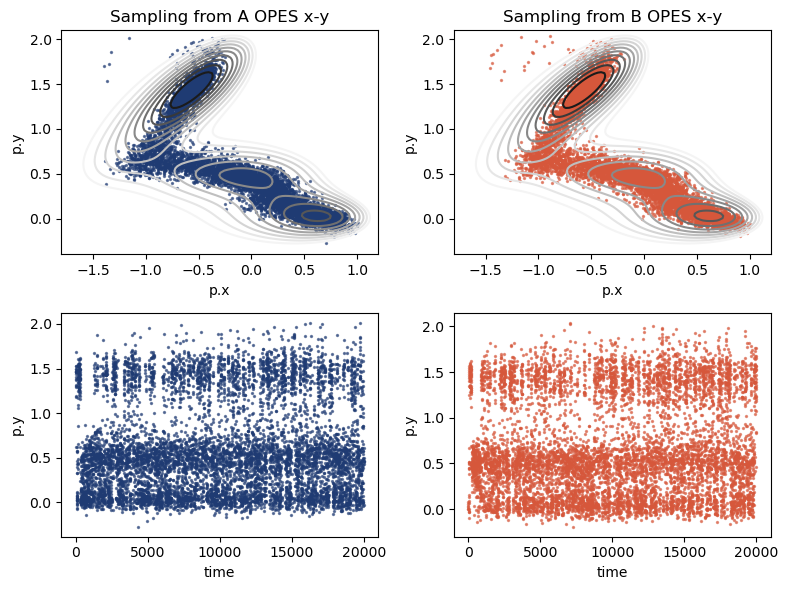

In [ ]:
from mlcolvar.utils.io import load_dataframe

# load data
sampling = load_dataframe([f'simulations/opes_metad_x-y/A/COLVAR', f'simulations/opes_metad_x-y/B/COLVAR'], start=0)

# plot data
fig, axs = plt.subplots(2,2,figsize=(8,6))
for i,s in enumerate(['A', 'B']):
    ax = axs[0, i]
    plot_isolines_2D(muller_brown_potential, levels=np.linspace(0,24, 12), max_value=24, ax=ax, colorbar=False, mode='contour')
    temp = sampling[sampling['walker'] == i]
    temp.plot.scatter('p.x', 'p.y', cmap='fessa',s=2, alpha=0.6, color=paletteFessa[0 + 6*i], ax=ax)
    ax.set_title(f'Sampling from {s} OPES x-y')
    
    ax = axs[1, i]
    temp.plot.scatter('time', 'p.y', c=paletteFessa[0 + 6*i], s=2, alpha=0.6, ax=ax)

plt.tight_layout()
plt.show()